In [1]:
import os
import shutil

import gym
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import shutil


from itertools import count
from collections import namedtuple
from collections import defaultdict
from torch.autograd import Variable
from tqdm import tnrange
from random import choice

from complex_gridword import GridworldEnv
from nets import *
from draw_methods import *
from hyper_parametrs import *
from env_methods import *
from tensorboardX import SummaryWriter
from utils import command

In [2]:
feature_extractor_layer1_size = 100
feature_extractor_layer2_size = 100

similarity_layer1_size = 100

In [3]:
class SiameseNet(nn.Module):
    def __init__(self, state_dim):
        super(SiameseNet, self).__init__()
        
        self.state_dim = state_dim
        
        self.feature_extractor = nn.Sequential(nn.Linear(state_dim, feature_extractor_layer1_size), nn.ReLU(),
                                               nn.Linear(feature_extractor_layer1_size, feature_extractor_layer2_size), nn.ReLU()
                                               )
        self.similarity = nn.Sequential(nn.Linear(2 * feature_extractor_layer2_size, similarity_layer1_size), nn.ReLU(),
                                               nn.Linear(similarity_layer1_size, 1), nn.Sigmoid()
                                               )
        
    def to_one_hot(self, states):
        states_one_hot = np.zeros((len(states), self.state_dim))
        for i in range(len(states)):
            states_one_hot[i][states[i]] = 1

        return Variable(torch.FloatTensor(states_one_hot), requires_grad=False)
        
    def forward(self, X):
        s1_one_hot = self.to_one_hot(X[:, 0])
        s2_one_hot = self.to_one_hot(X[:, 1])
        s1_features = self.feature_extractor(s1_one_hot)
        s2_features = self.feature_extractor(s2_one_hot)
        return self.similarity(torch.cat([s1_features, s2_features], dim=-1))

In [4]:
grid_size = (5, 5)
env = GridworldEnv(shape=grid_size, grid_map=np.load("gridworlds_data/simple_{}x{}/grid_map.npy".format(grid_size[0], grid_size[1])))

In [5]:
state_dim = int(env.nS)
action_dim = int(env.nA)

In [6]:
def play_random_policy(env, trajectory_len=100):
    trajectory = []
    set_random_s0(env)
    s = env.reset()
    trajectory.append(s)
    while(len(trajectory) < trajectory_len):
        a = np.random.randint(action_dim)
        s, _, done, _= env.step(a)
        trajectory.append(s)
    return trajectory

def get_sim_unsim_pairs(trajectory, sim_threshold, unsim_threshold, balance_proportion=4.0):
    global possitive_pairs
    global negative_pairs
    X_batch = []
    y_batch = []
    possitive = 0
    for i in range(len(trajectory)):
        for j in range(i, min(i + sim_threshold + 1, len(trajectory))):
            X_batch.append((trajectory[i], trajectory[j]))
            y_batch.append(1)
            possitive += 1
            #possitive_pairs.append((trajectory[i], trajectory[j]))
    
    negative = 0
    for i in range(len(trajectory) - 1):
        if negative / possitive > balance_proportion:
            break
        for j in range(i + unsim_threshold + 1, len(trajectory)):
            X_batch.append((trajectory[i], trajectory[j]))
            #negative_pairs.append((trajectory[i], trajectory[j]))
            y_batch.append(0)
            negative += 1
    
    return np.array(X_batch), np.array(y_batch)

from tqdm import tnrange

def get_test_acc(net, X_test, y_test, possitive_bound=0.1):
    predicted = net(X_test) > possitive_bound

    acc = np.sum(predicted.data.numpy().flatten() == y_test.flatten()) / len(y_test)
    return acc

def draw_heat_map(siam_net, env):
    root_ns = int(env.nS ** (1.0 / 2))
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    for j, start_state in enumerate([0, env.nS // 2, env.nS - 1]):
        test = np.array([(start_state, i) for i in range(env.nS)])
        heat_map = np.zeros((root_ns, root_ns))
        probs = siam_net(test).data.numpy()
        for i in range(env.nS):
             heat_map[i // root_ns][i % root_ns] = probs[i] * env.grid_map[i]
        ax[j].imshow(heat_map, cmap="hot")
        ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//root_ns, start_state%root_ns))

from IPython.display import clear_output
def train_siam_net(siam_net, optimizer,  env, episodes, sim_threshold, unsim_threshold, balance_proportion, X_test, y_test, trajectory_len, verbose_every=250):
    history_loss = []
    for i in tnrange(episodes):
        episode_trajectory = play_random_policy(env, trajectory_len)
        X, y = get_sim_unsim_pairs(episode_trajectory, sim_threshold, unsim_threshold, balance_proportion)
        
        y = Variable(torch.FloatTensor(y.reshape(-1, 1)))
        
        optimizer.zero_grad()
        #print(X.shape)
        predicted = siam_net(X)
        loss = nn.BCELoss()(predicted, y)
        if i % verbose_every == 0:
            history_loss.append(get_test_acc(siam_net, X_test, y_test))
            clear_output()
            plt.plot(history_loss)
            draw_heat_map(siam_net, env)
            plt.show()
        
        loss.backward()
        optimizer.step()
    return history_loss

In [18]:
env_name = "simple"
Expert_left_corner = NovelExpert("left_top_corner", np.load("gridworlds_data/{}_{}x{}/agents_left_corner/action_probs.npy".format(env_name, grid_size[0], grid_size[1])), 
                            np.load("gridworlds_data/{}_{}x{}/agents_left_corner/value_function.npy".format(env_name, grid_size[0], grid_size[1])),
                            np.load("gridworlds_data/{}_{}x{}/agents_left_corner/goal_map.npy".format(env_name, grid_size[0], grid_size[1])))
Expert_right_corner = NovelExpert("right_bottom_corner", np.load("gridworlds_data/{}_{}x{}/agents_right_corner/action_probs.npy".format(env_name, grid_size[0], grid_size[1])), 
                            np.load("gridworlds_data/{}_{}x{}/agents_right_corner/value_function.npy".format(env_name, grid_size[0], grid_size[1])),
                            np.load("gridworlds_data/{}_{}x{}/agents_right_corner/goal_map.npy".format(env_name, grid_size[0], grid_size[1])))

In [19]:
def goal_unsim(env, g1, g2, env_type="simple"):
    if env.grid_map[g1] == 0 or env.grid_map[g2] == 0:
            return 1000
    if env_type == "simple" or "pillar":
        return (abs(g1 % int(np.sqrt(env.nS)) - g2 % int(np.sqrt(env.nS))) + abs(g1 // int(np.sqrt(env.nS)) - g2 // int(np.sqrt(env.nS))))
    if env_type == "snake":
        if env.grid_map[g1] == 0 or env.grid_map[g2] == 0:
            return 1000
        r1 = np.abs(Expert_left_corner.v_function[g1] - Expert_left_corner.v_function[g2])
        r2 = np.abs(Expert_right_corner.v_function[g1] - Expert_right_corner.v_function[g2])
        return min(r1, r2)
    raise Exception
    
def get_test_examples(env, state_dim, sim_thresh, env_type="simple"):
    X = []
    y = []
    
    for i in range(state_dim):
        for j in range(state_dim):
            X.append((i, j))
            y.append(int(goal_unsim(env, i, j, env_type) <= sim_thresh))
    return np.array(X), np.array(y)

In [23]:
X_test, y_test = get_test_examples(env, state_dim , 2, "simple")

In [26]:
siam_net = SiameseNet(state_dim)
optimizer = torch.optim.Adam(siam_net.parameters(), lr=1e-3) #for 5x5 snake 5e4

possitive_pairs = []
negative_pairs = []

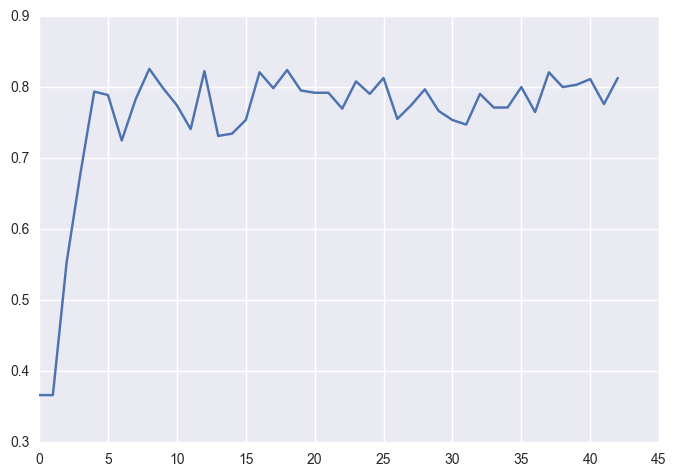

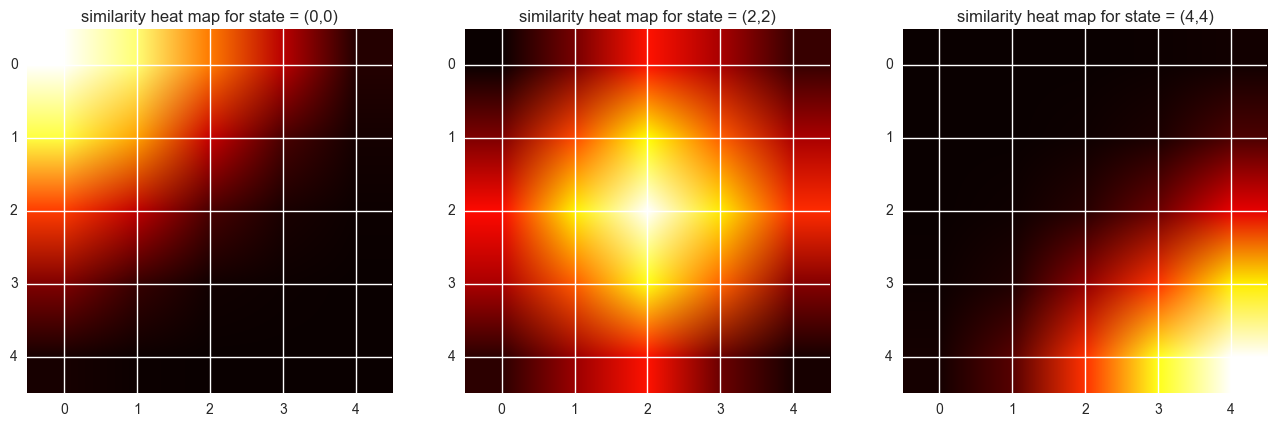

KeyboardInterrupt: 

In [27]:
train_siam_net(siam_net, optimizer,  env, 30000, 4, 50, 4, X_test, y_test, trajectory_len=80, verbose_every=250)

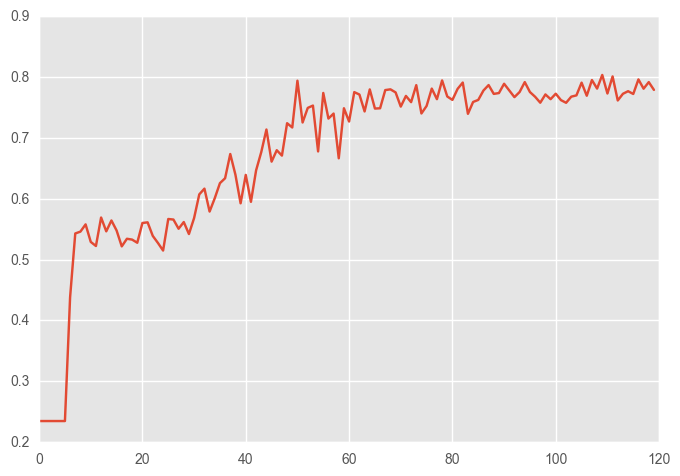

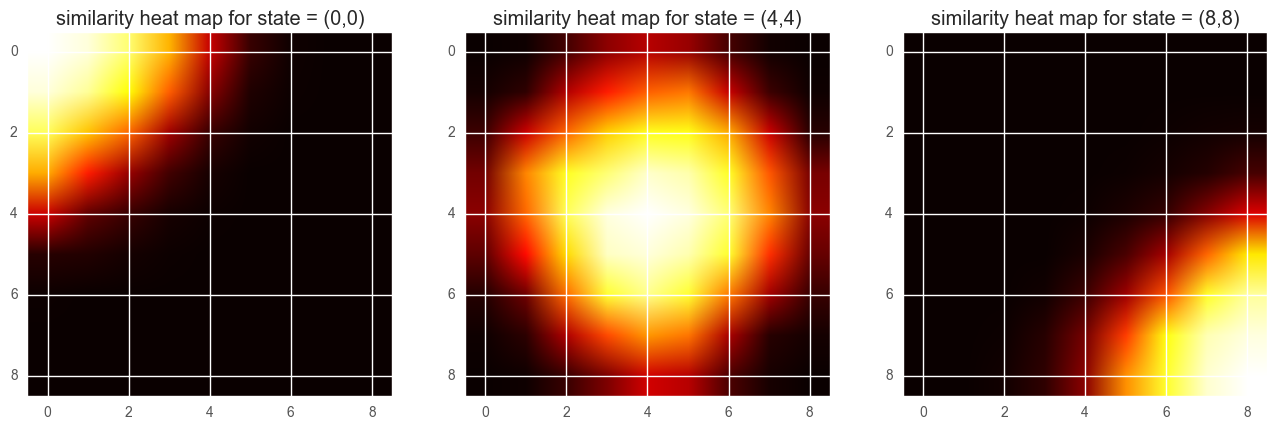

In [ ]:
train_siam_net(siam_net, optimizer,  env, 30000, 6, 150, 4, X_test, y_test, trajectory_len=200, verbose_every=250)

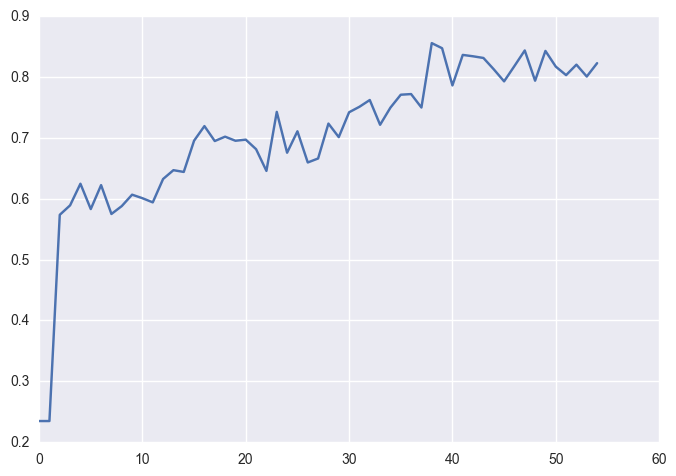

In [ ]:
train_siam_net(siam_net, optimizer,  env, 30000, 6, 150, 4, X_test, y_test, trajectory_len=200, verbose_every=250)

In [68]:
torch.save(siam_net, "pretrained_nets/siamese_simple_9x9.pt",)

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
test = np.array([(0, i) for i in range(env.nS)])
siam_net(test).view((9, 9))

Variable containing:

Columns 0 to 5 
 9.7594e-01  9.5375e-01  8.8109e-01  6.6679e-01  2.7320e-01  7.7301e-02
 9.4213e-01  8.8785e-01  7.8431e-01  4.1837e-01  1.5783e-01  3.1744e-02
 8.6915e-01  7.0602e-01  5.5094e-01  1.9718e-01  6.8345e-02  1.1248e-02
 7.0363e-01  4.6337e-01  1.9841e-01  9.4190e-02  2.3925e-02  4.0830e-03
 2.6428e-01  1.0532e-01  4.8327e-02  2.1722e-02  6.2846e-03  9.3300e-04
 3.6754e-02  2.0843e-02  1.0653e-02  4.9898e-03  1.4854e-03  2.1051e-04
 4.2376e-03  2.5121e-03  1.5450e-03  8.0847e-04  3.8967e-04  6.7068e-05
 5.6205e-04  3.0253e-04  1.9474e-04  1.1859e-04  8.3242e-05  1.8315e-05
 1.1731e-04  5.0866e-05  3.1935e-05  2.3855e-05  1.2370e-05  4.7415e-06

Columns 6 to 8 
 1.4411e-02  2.7937e-03  3.7031e-04
 6.4056e-03  1.0883e-03  1.7482e-04
 2.1740e-03  4.5747e-04  5.8227e-05
 6.8465e-04  1.8554e-04  1.9133e-05
 1.5805e-04  3.7176e-05  6.4683e-06
 5.0035e-05  1.1299e-05  1.5841e-06
 1.3987e-05  2.6403e-06  5.1370e-07
 3.1934e-06  4.3501e-07  9.9642e-08
 8.8937e-

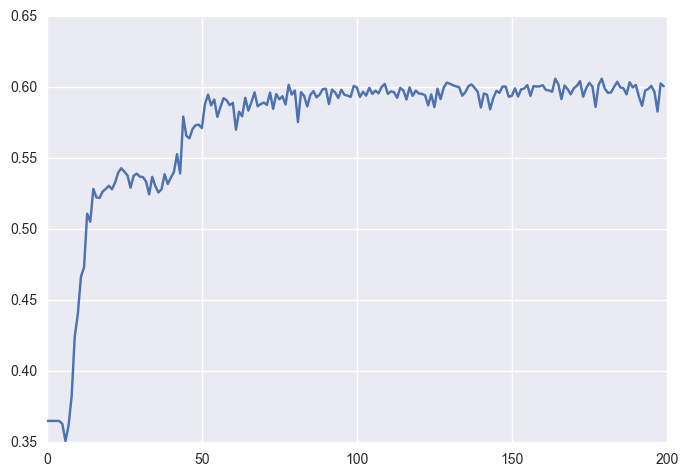

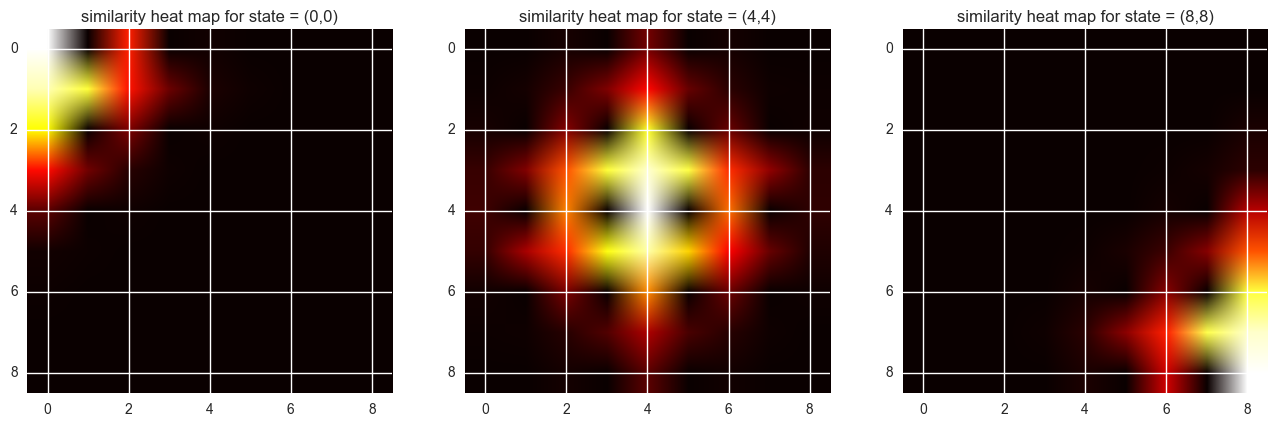

In [17]:
train_siam_net(siam_net, optimizer,  env, 50000, 7, 100, 4, X_test, y_test, trajectory_len=150)

In [18]:
torch.save(siam_net, "pretrained_nets/siamese_pillar_9x9.pt",)

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
test = np.array([(0, i) for i in range(env.nS)])
siam_net(test).view((7, 7))

Variable containing:

Columns 0 to 5 
 9.5089e-01  1.0047e-02  1.4912e-01  2.3043e-03  4.7918e-03  1.6571e-02
 9.0802e-01  7.2580e-01  3.0995e-01  8.9068e-02  1.5944e-02  1.6770e-03
 7.3919e-01  1.4924e-03  1.1268e-01  2.2541e-03  3.3849e-03  2.2863e-03
 3.7758e-01  1.1481e-01  3.1894e-02  5.1298e-03  7.7857e-04  7.8486e-05
 1.2058e-01  1.9935e-03  4.4963e-03  8.7426e-04  1.1686e-04  1.5049e-03
 1.6927e-02  2.9496e-03  8.5745e-04  8.6656e-05  2.7086e-05  3.0121e-06
 1.4084e-02  4.5652e-02  1.0922e-04  2.7530e-03  6.1694e-06  2.0660e-03

Columns 6 to 6 
 3.9516e-05
 1.6167e-04
 3.4220e-05
 1.4002e-05
 3.6221e-06
 8.3089e-07
 1.5224e-07
[torch.FloatTensor of size 7x7]

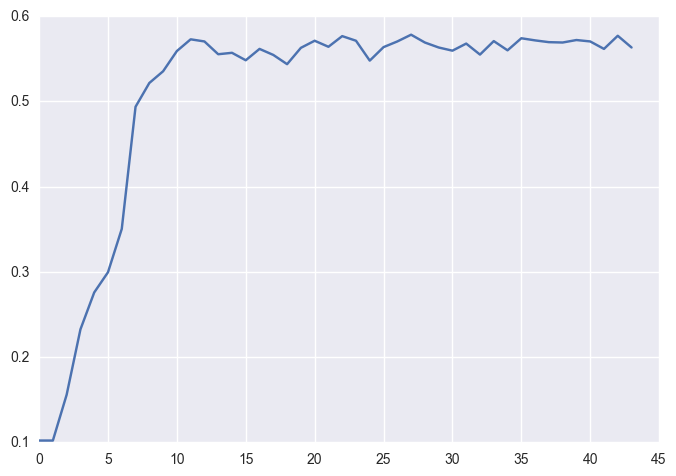

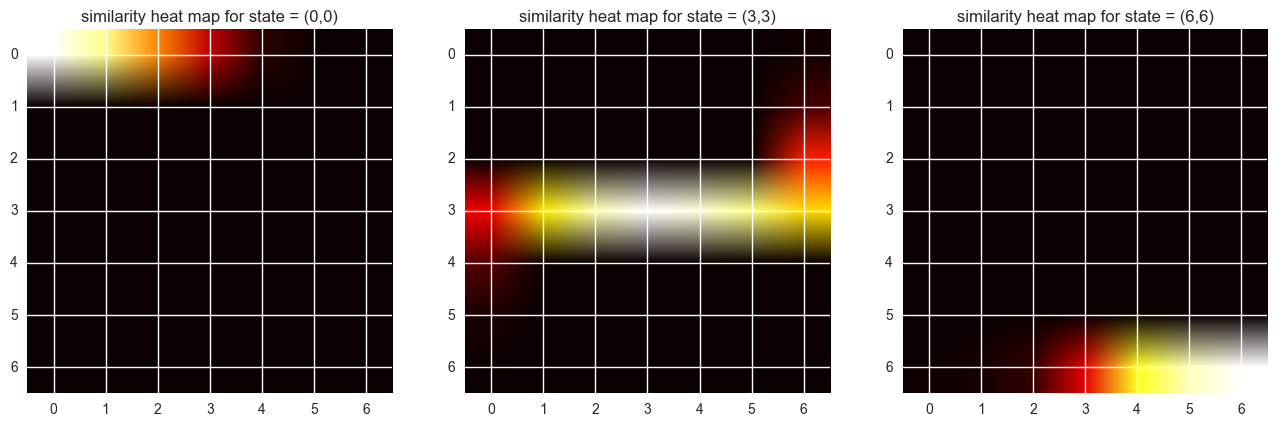

KeyboardInterrupt: 

In [119]:
train_siam_net(siam_net, optimizer,  env, 30000, 6, 200, 4, X_test, y_test, trajectory_len=250, verbose_every=250)

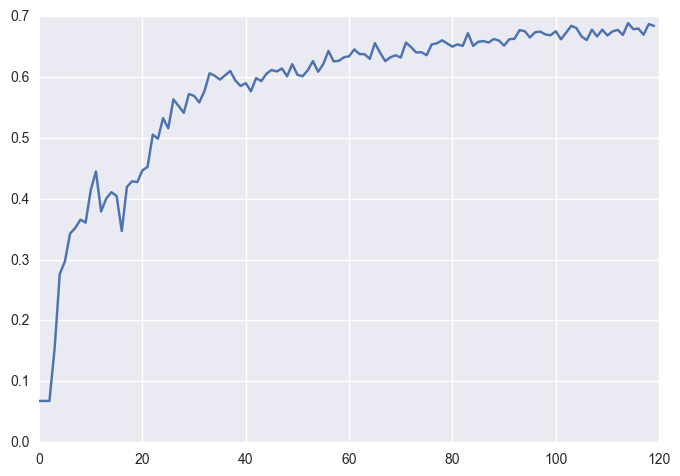

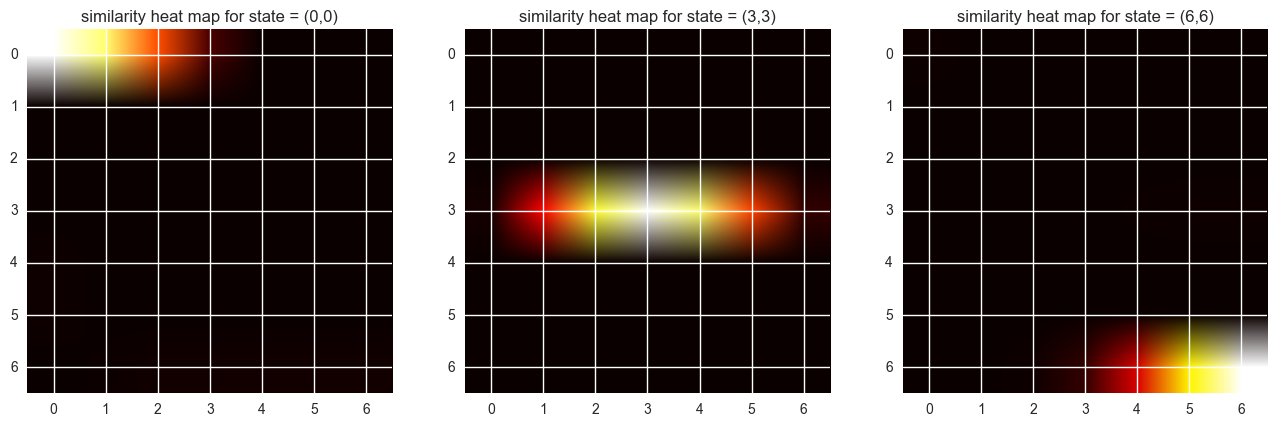

In [108]:
train_siam_net(siam_net, optimizer,  env, 30000, 10, 200, 4, X_test, y_test, trajectory_len=250, verbose_every=250)

In [109]:
test = np.array([(0, i) for i in range(env.nS)])
siam_net(test)

Variable containing:
 0.8528
 0.6293
 0.2837
 0.0391
 0.0024
 0.0007
 0.0000
 0.3607
 0.1552
 0.1979
 0.3027
 0.0984
 0.0971
 0.0000
 0.3469
 0.1447
 0.3655
 0.2488
 0.1363
 0.1137
 0.0001
 0.0015
 0.0014
 0.0017
 0.0012
 0.0004
 0.0002
 0.0003
 0.0069
 0.2050
 0.2399
 0.0943
 0.3373
 0.0186
 0.3068
 0.0056
 0.1458
 0.0740
 0.0960
 0.2023
 0.1760
 0.3323
 0.0025
 0.0042
 0.0096
 0.0108
 0.0138
 0.0177
 0.0193
[torch.FloatTensor of size 49x1]

In [110]:
torch.save(siam_net, "pretrained_nets/siamese_snake_7x7.pt",)

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


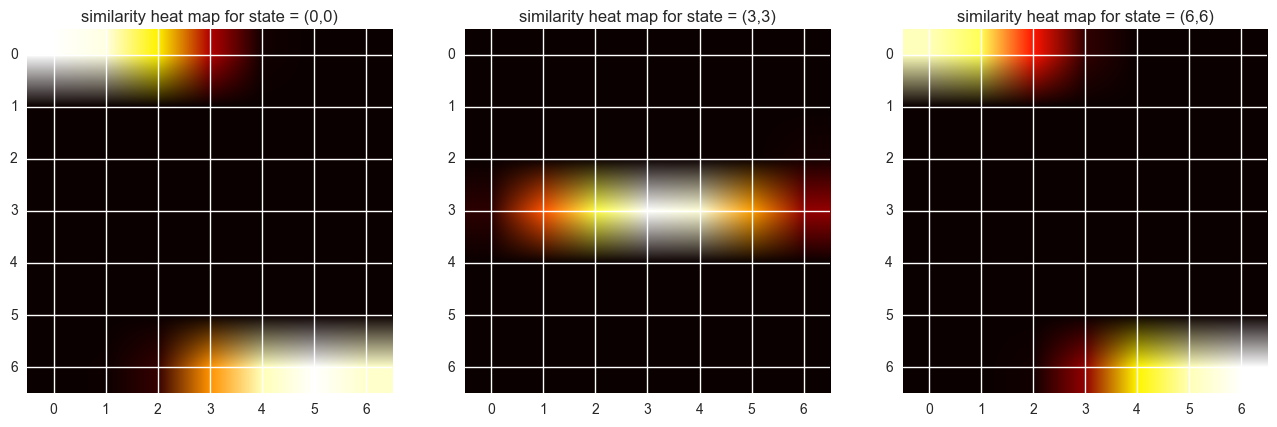

In [96]:
root_ns = int(env.nS ** (1.0 / 2))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
for j, start_state in enumerate([0, env.nS // 2, env.nS - 1]):
    test = np.array([(start_state, i) for i in range(env.nS)])
    heat_map = np.zeros((root_ns, root_ns))
    probs = siam_net(test).data.numpy()
    for i in range(env.nS):
         heat_map[i // root_ns][i % root_ns] = probs[i] * env.grid_map[i]
    ax[j].imshow(heat_map, cmap="hot")
    ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//root_ns, start_state%root_ns))
plt.show()

In [18]:
torch.save(siam_net, "pretrained_nets/siamese_snake_7x7.pt",)

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
test = np.array([(24, i) for i in range(env.nS)])

In [17]:
siam_net(test)

Variable containing:
 4.9801e-03
 1.2408e-03
 7.1863e-04
 1.0179e-03
 3.1026e-04
 6.8557e-04
 1.8384e-03
 9.0588e-04
 2.8501e-03
 1.5637e-04
 3.2590e-06
 6.9453e-07
 1.3315e-07
 1.0989e-06
 8.5915e-06
 1.9637e-05
 5.0151e-03
 1.4275e-02
 4.7931e-02
 4.5152e-03
 7.0179e-04
 1.6359e-02
 1.6004e-01
 5.6872e-01
 8.3371e-01
[torch.FloatTensor of size 25x1]

In [165]:
siam_net(test)

Variable containing:
 8.9163e-01
 7.1012e-01
 2.6675e-01
 4.8829e-03
 4.7797e-05
 6.4915e-01
 6.3418e-01
 7.7201e-01
 5.4314e-01
 4.4403e-06
 1.3086e-05
 2.3698e-06
 7.7785e-06
 1.6901e-05
 5.5263e-06
 3.9002e-05
 7.2924e-01
 7.8765e-01
 6.2815e-01
 6.2574e-01
 3.6123e-06
 6.2099e-05
 9.4035e-05
 3.0347e-04
 6.5741e-05
[torch.FloatTensor of size 25x1]

In [86]:
print("%d%d"%(1, 2))

12


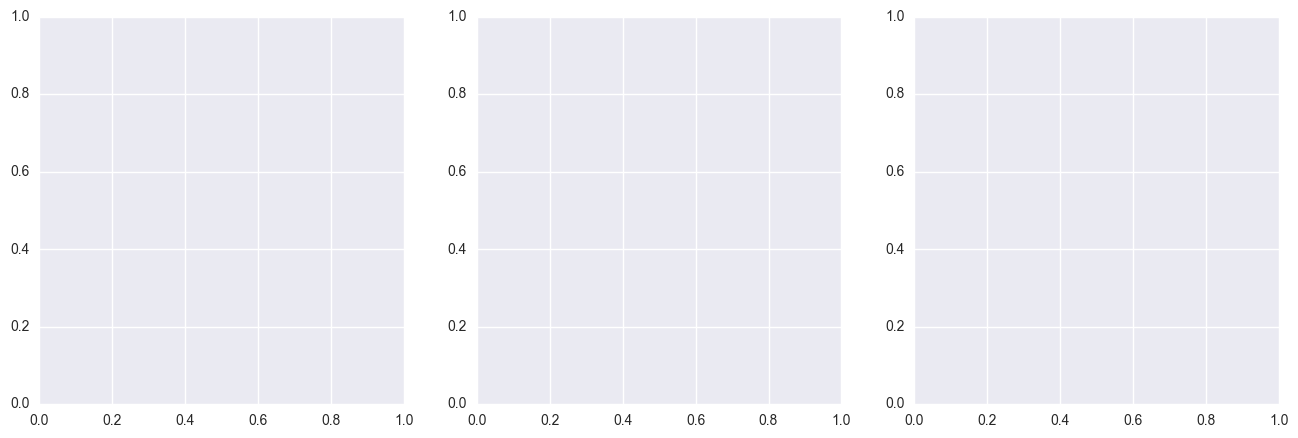

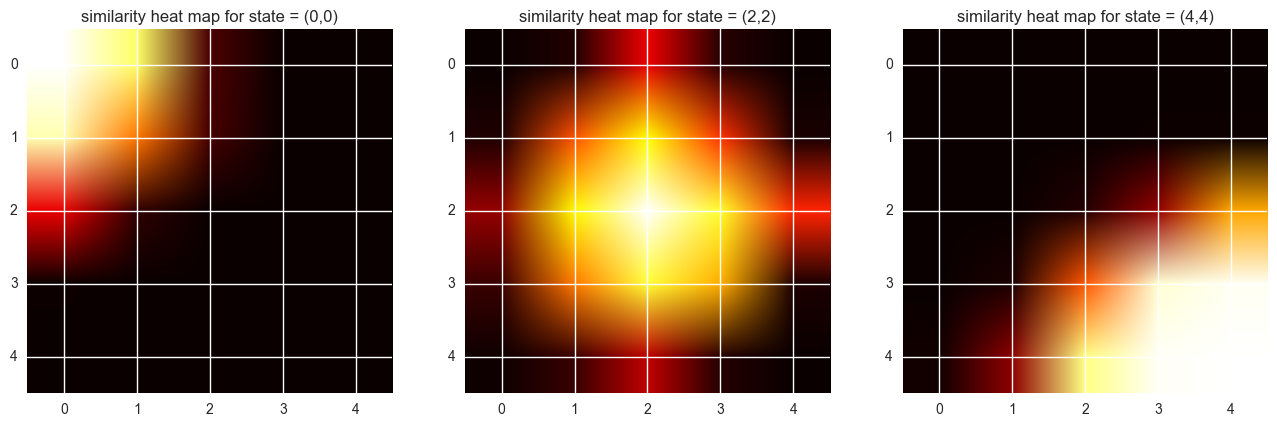

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
for j, start_state in enumerate([0, 12, 24]):
    test = np.array([(start_state, i) for i in range(25)])
    heat_map = np.zeros((5, 5))
    probs = siam_net(test).data.numpy()
    for i in range(25):
         heat_map[i // 5][i % 5] = probs[i]
    ax[j].imshow(heat_map, cmap="hot")
    ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//5, start_state%5))
plt.show()

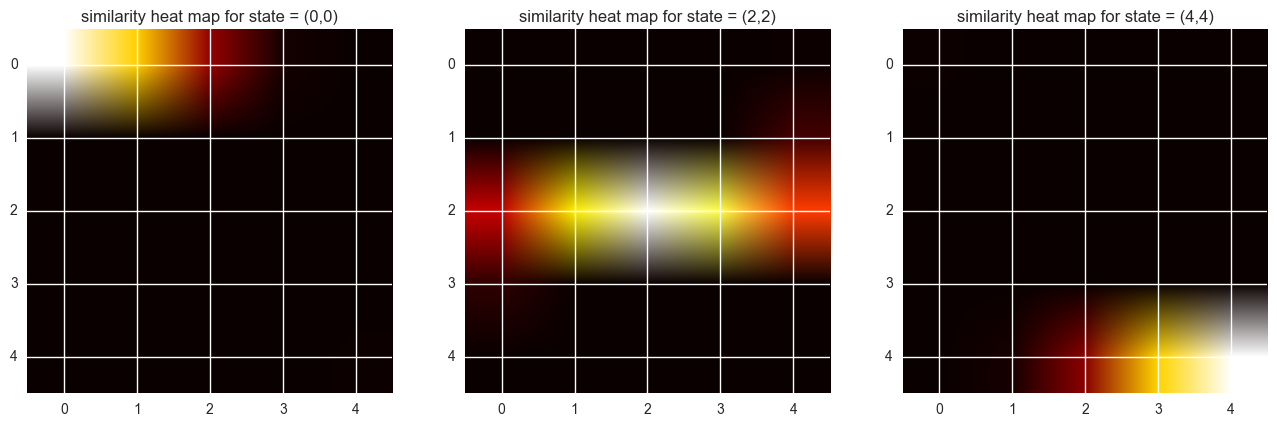

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
for j, start_state in enumerate([0, 12, 24]):
    test = np.array([(start_state, i) for i in range(25)])
    heat_map = np.zeros((5, 5))
    probs = siam_net(test).data.numpy()
    for i in range(25):
         heat_map[i // 5][i % 5] = probs[i] * env.grid_map[i]
    ax[j].imshow(heat_map, cmap="hot")
    ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//5, start_state%5))
plt.show()

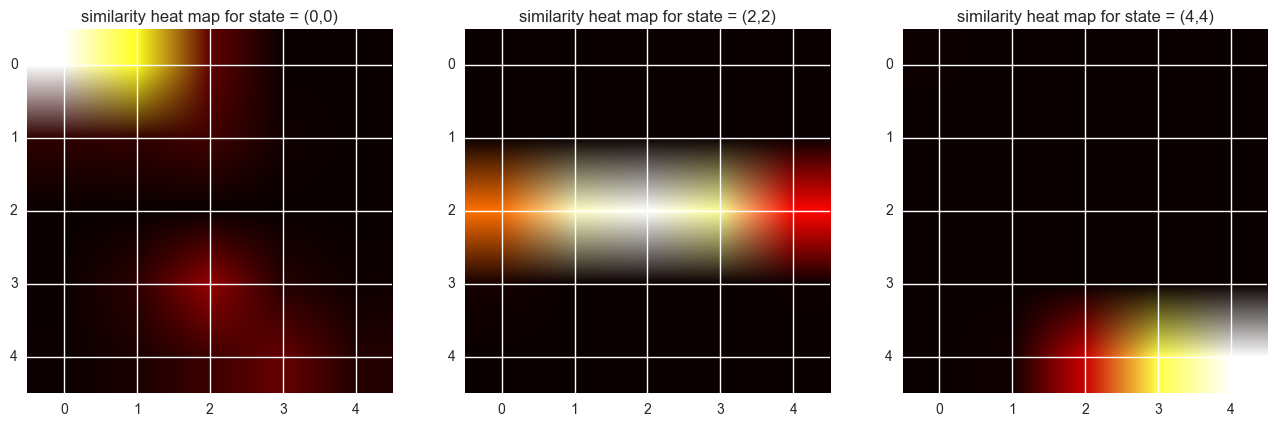

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
for j, start_state in enumerate([0, 12, 24]):
    test = np.array([(start_state, i) for i in range(25)])
    heat_map = np.zeros((5, 5))
    probs = siam_net(test).data.numpy()
    for i in range(25):
         heat_map[i // 5][i % 5] = probs[i]
    ax[j].imshow(heat_map, cmap="hot")
    ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//5, start_state%5))
plt.show()

In [89]:
root_ns = int(env.nS ** (1.0 / 2))
root_ns

7

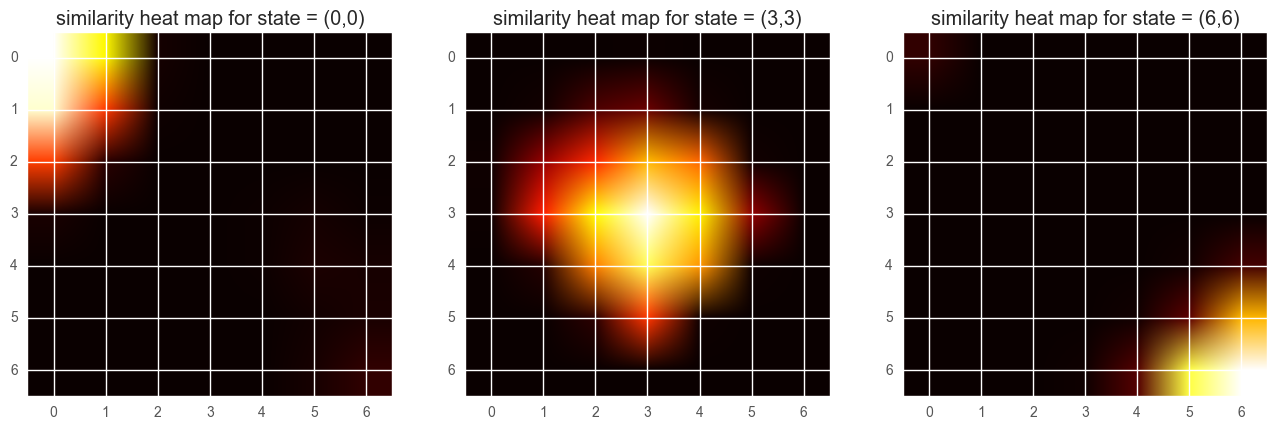

In [91]:
root_ns = int(env.nS ** (1.0 / 2))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
for j, start_state in enumerate([0, env.nS // 2, env.nS - 1]):
    test = np.array([(start_state, i) for i in range(env.nS)])
    heat_map = np.zeros((root_ns, root_ns))
    probs = siam_net(test).data.numpy()
    for i in range(env.nS):
         heat_map[i // root_ns][i % root_ns] = probs[i]
    ax[j].imshow(heat_map, cmap="hot")
    ax[j].set_title("similarity heat map for state = (%d,%d)"%(start_state//root_ns, start_state%root_ns))
plt.show()

In [95]:
test = np.array([(0, i) for i in range(env.nS)])
siam_net(test)

Variable containing:
 9.9193e-01
 7.3112e-01
 1.8629e-02
 2.6152e-04
 1.6091e-06
 6.7735e-09
 1.5307e-09
 9.4534e-01
 4.4598e-01
 8.7784e-03
 1.6941e-04
 4.5275e-06
 6.0529e-06
 6.3871e-07
 4.5353e-01
 4.7642e-02
 9.8225e-04
 5.3883e-05
 2.4402e-04
 1.6066e-03
 4.8495e-04
 2.3873e-02
 3.4727e-03
 6.0377e-05
 3.3226e-04
 6.7233e-03
 1.8428e-02
 7.1528e-03
 1.9775e-04
 6.0681e-05
 1.3746e-04
 3.5441e-04
 4.8789e-03
 2.9760e-02
 2.2398e-02
 5.8577e-07
 1.0579e-05
 9.5359e-05
 4.6144e-04
 2.8422e-03
 1.5081e-02
 2.5104e-02
 3.5058e-07
 6.1289e-07
 2.6883e-05
 5.4567e-04
 2.7388e-03
 2.1356e-02
 5.9584e-02
[torch.FloatTensor of size 49x1]

In [96]:
def to_one_hot(states):
    states_one_hot = np.zeros((len(states), state_dim))
    for i in range(len(states)):
        states_one_hot[i][states[i]] = 1
        
    return Variable(torch.FloatTensor(output), requires_grad=False)

output = to_one_hot(s)
print("1")

NameError: name 's' is not defined

In [141]:
output

Variable containing:

Columns 0 to 12 
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 24 
    0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     1
[torch.FloatTensor of size 2x25]

In [131]:
output[1]

Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
[torch.FloatTensor of size 25]